# MIS 583 Assignment 4: Self-supervised and transfer learning on CIFAR10

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 陳羽楨, B094020019.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as Func
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img        #                           
    #######################################################################
    elif rot == 1: # 90 degrees 
        return Func.rotate(img, 90)
    elif rot == 2: # 180 degrees 
        return Func.rotate(img, 180)
    elif rot == 3: # 270 degrees 
        return Func.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


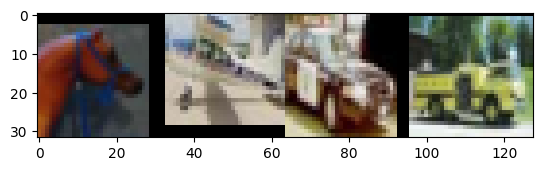

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  horse plane car   truck


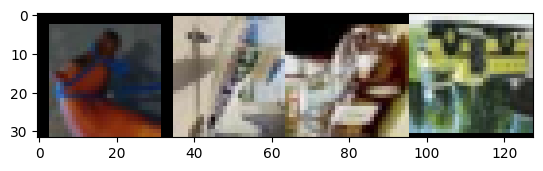

Rotation labels:  90    270   90    180  


In [4]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [5]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) #總共幾類
            correct += (predicted == labels).sum().item() #對的有幾個
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [6]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#之後可改learning rate scheduler

# Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Notice: You should not use pretrained weights from ImageNet.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [10]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #  
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)
            
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################                                            


            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        net.eval()
        run_test(net, testloader, criterion, task) 
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################  

    print('Finished Training')
    
    try:
        if trainloader:
            trainloader.shutdown()
        if testloader:
            testloader.shutdown()
    except Exception as e:
        pass

In [12]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #  
################################
torch.save(net.state_dict(), 'A4-1save.pt')
################################
#      End of your code        #  
################################

[1,   100] loss: 0.688 acc: 74.02 time: 2.57
[1,   200] loss: 0.650 acc: 74.12 time: 2.26
[1,   300] loss: 0.646 acc: 74.34 time: 2.25
TESTING:
Accuracy of the network on the 10000 test images: 74.61 %
Average loss on the 10000 test images: 0.652
[2,   100] loss: 0.644 acc: 74.81 time: 2.34
[2,   200] loss: 0.632 acc: 74.98 time: 2.24
[2,   300] loss: 0.648 acc: 74.47 time: 2.26
TESTING:
Accuracy of the network on the 10000 test images: 75.44 %
Average loss on the 10000 test images: 0.618
[3,   100] loss: 0.628 acc: 74.80 time: 2.36
[3,   200] loss: 0.616 acc: 75.73 time: 2.31
[3,   300] loss: 0.627 acc: 75.62 time: 2.29
TESTING:
Accuracy of the network on the 10000 test images: 75.67 %
Average loss on the 10000 test images: 0.634
[4,   100] loss: 0.828 acc: 66.93 time: 2.33
[4,   200] loss: 0.717 acc: 71.83 time: 2.25
[4,   300] loss: 0.677 acc: 73.44 time: 2.29
TESTING:
Accuracy of the network on the 10000 test images: 75.62 %
Average loss on the 10000 test images: 0.620
[5,   100] l

## Fine-tuning on the pre-trained model (9 points)

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [11]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################
net.load_state_dict(torch.load('A4-1save.pt'))
net.fc = nn.Linear(512,10)
print(net) # print your model and check the num_classes is correct
####################################################
#                End of your code                  #   
####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
from torch import nn
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################
for name, child in net.named_children():
    if name not in ['layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True

net = net.to(device)
#################################################################################################
#                                          End of your code                                     #
#################################################################################################

In [13]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [14]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

In [15]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.02, task='classification')

torch.save(net.state_dict(), 'A4-2save.pt')


[1,   100] loss: 1.989 acc: 23.87 time: 2.61
[1,   200] loss: 1.583 acc: 40.38 time: 2.31
[1,   300] loss: 1.449 acc: 46.38 time: 2.29
TESTING:
Accuracy of the network on the 10000 test images: 49.55 %
Average loss on the 10000 test images: 1.419
[2,   100] loss: 1.356 acc: 50.38 time: 2.42
[2,   200] loss: 1.375 acc: 49.92 time: 2.25
[2,   300] loss: 1.360 acc: 50.02 time: 2.24
TESTING:
Accuracy of the network on the 10000 test images: 53.02 %
Average loss on the 10000 test images: 1.305
[3,   100] loss: 1.318 acc: 52.25 time: 2.34
[3,   200] loss: 1.292 acc: 52.74 time: 2.25
[3,   300] loss: 1.286 acc: 53.37 time: 2.29
TESTING:
Accuracy of the network on the 10000 test images: 54.11 %
Average loss on the 10000 test images: 1.313
[4,   100] loss: 1.292 acc: 52.48 time: 2.38
[4,   200] loss: 1.271 acc: 53.87 time: 2.27
[4,   300] loss: 1.269 acc: 54.62 time: 2.28
TESTING:
Accuracy of the network on the 10000 test images: 55.68 %
Average loss on the 10000 test images: 1.238
[5,   100] l

## Fine-tuning on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################

#Truncated normal initialization
net= resnet18()

def truncated_normal_init(m):
    if isinstance(m, nn.Conv2d or nn.Linear):
        torch.nn.init.trunc_normal_(m.weight, 0, 0.1) 
net.apply(truncated_normal_init)

net.fc = nn.Linear(512,10)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################
for name, child in net.named_children():
    if name not in ['layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True

# net.fc = nn.Linear(512,10)
net = net.to(device)
#################################################################################################
#                                          End of your code                                     #
#################################################################################################


In [18]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [19]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

In [20]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.233 acc: 25.01 time: 2.42
[1,   200] loss: 1.915 acc: 30.57 time: 2.33
[1,   300] loss: 1.856 acc: 32.99 time: 2.29
TESTING:
Accuracy of the network on the 10000 test images: 37.48 %
Average loss on the 10000 test images: 1.733
[2,   100] loss: 1.811 acc: 34.91 time: 2.39
[2,   200] loss: 1.799 acc: 34.26 time: 2.29
[2,   300] loss: 1.765 acc: 36.18 time: 2.30
TESTING:
Accuracy of the network on the 10000 test images: 37.75 %
Average loss on the 10000 test images: 1.721
[3,   100] loss: 1.748 acc: 36.45 time: 2.39
[3,   200] loss: 1.737 acc: 37.10 time: 2.30
[3,   300] loss: 1.751 acc: 36.88 time: 2.30
TESTING:
Accuracy of the network on the 10000 test images: 40.59 %
Average loss on the 10000 test images: 1.657
[4,   100] loss: 1.727 acc: 37.89 time: 2.37
[4,   200] loss: 1.711 acc: 38.30 time: 2.29
[4,   300] loss: 1.714 acc: 38.59 time: 2.30
TESTING:
Accuracy of the network on the 10000 test images: 40.21 %
Average loss on the 10000 test images: 1.646
[5,   100] l

## Supervised training on the pre-trained model (9 points)
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [43]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################
# net.load_state_dict(torch.load('A4-1save.pt'))
pretrained_dict = torch.load('A4-1save.pt')  
net_dict = net.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith('fc.')}  


net_dict.update(pretrained_dict) 
net.load_state_dict(net_dict)

net.load_state_dict(torch.load('A4-2save.pt'), strict=False)


print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #   
#####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [45]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.103 acc: 60.47 time: 2.45
[1,   200] loss: 1.008 acc: 64.04 time: 2.35
[1,   300] loss: 0.946 acc: 66.38 time: 2.35
TESTING:
Accuracy of the network on the 10000 test images: 71.54 %
Average loss on the 10000 test images: 0.815
[2,   100] loss: 0.848 acc: 70.56 time: 2.40
[2,   200] loss: 0.834 acc: 71.13 time: 2.28
[2,   300] loss: 0.820 acc: 71.58 time: 2.27
TESTING:
Accuracy of the network on the 10000 test images: 73.50 %
Average loss on the 10000 test images: 0.777
[3,   100] loss: 0.766 acc: 73.11 time: 2.40
[3,   200] loss: 0.747 acc: 73.84 time: 2.30
[3,   300] loss: 0.736 acc: 74.18 time: 2.27
TESTING:
Accuracy of the network on the 10000 test images: 74.40 %
Average loss on the 10000 test images: 0.732
[4,   100] loss: 0.710 acc: 74.96 time: 2.42
[4,   200] loss: 0.707 acc: 75.56 time: 2.32
[4,   300] loss: 0.679 acc: 76.11 time: 2.31


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/cvlab/anaconda3/envs/stanet/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462

TESTING:
Accuracy of the network on the 10000 test images: 76.68 %
Average loss on the 10000 test images: 0.672
[5,   100] loss: 0.651 acc: 77.44 time: 2.42
[5,   200] loss: 0.660 acc: 77.09 time: 2.31
[5,   300] loss: 0.637 acc: 78.12 time: 2.31


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/cvlab/anaconda3/envs/stanet/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462

TESTING:
Accuracy of the network on the 10000 test images: 76.73 %
Average loss on the 10000 test images: 0.661
[6,   100] loss: 0.619 acc: 78.29 time: 2.43
[6,   200] loss: 0.613 acc: 78.73 time: 2.32
[6,   300] loss: 0.618 acc: 78.33 time: 2.30
TESTING:
Accuracy of the network on the 10000 test images: 79.04 %
Average loss on the 10000 test images: 0.615
[7,   100] loss: 0.602 acc: 79.02 time: 2.42
[7,   200] loss: 0.576 acc: 79.92 time: 2.36
[7,   300] loss: 0.586 acc: 79.65 time: 2.35
TESTING:
Accuracy of the network on the 10000 test images: 78.58 %
Average loss on the 10000 test images: 0.624
[8,   100] loss: 0.574 acc: 79.94 time: 2.45
[8,   200] loss: 0.573 acc: 80.16 time: 2.33
[8,   300] loss: 0.568 acc: 80.09 time: 2.34
TESTING:
Accuracy of the network on the 10000 test images: 78.78 %
Average loss on the 10000 test images: 0.627
[9,   100] loss: 0.529 acc: 81.38 time: 2.41
[9,   200] loss: 0.561 acc: 81.02 time: 2.30
[9,   300] loss: 0.532 acc: 81.55 time: 2.33
TESTING:
Acc

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/cvlab/anaconda3/envs/stanet/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462

TESTING:
Accuracy of the network on the 10000 test images: 80.50 %
Average loss on the 10000 test images: 0.574
[11,   100] loss: 0.478 acc: 83.40 time: 2.38
[11,   200] loss: 0.441 acc: 85.02 time: 2.27
[11,   300] loss: 0.440 acc: 84.83 time: 2.28
TESTING:
Accuracy of the network on the 10000 test images: 82.84 %
Average loss on the 10000 test images: 0.502
[12,   100] loss: 0.426 acc: 85.60 time: 2.46
[12,   200] loss: 0.420 acc: 85.58 time: 2.34
[12,   300] loss: 0.411 acc: 85.76 time: 2.34


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/cvlab/anaconda3/envs/stanet/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462

TESTING:
Accuracy of the network on the 10000 test images: 82.84 %
Average loss on the 10000 test images: 0.504
[13,   100] loss: 0.410 acc: 85.86 time: 2.37
[13,   200] loss: 0.402 acc: 86.06 time: 2.27
[13,   300] loss: 0.400 acc: 86.00 time: 2.28


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/cvlab/anaconda3/envs/stanet/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462

TESTING:
Accuracy of the network on the 10000 test images: 83.34 %
Average loss on the 10000 test images: 0.500
[14,   100] loss: 0.402 acc: 86.10 time: 2.38
[14,   200] loss: 0.396 acc: 86.26 time: 2.27
[14,   300] loss: 0.400 acc: 86.16 time: 2.27


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/cvlab/anaconda3/envs/stanet/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462

TESTING:
Accuracy of the network on the 10000 test images: 83.02 %
Average loss on the 10000 test images: 0.502
[15,   100] loss: 0.395 acc: 86.60 time: 2.44
[15,   200] loss: 0.398 acc: 86.22 time: 2.33
[15,   300] loss: 0.390 acc: 86.43 time: 2.34


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/cvlab/anaconda3/envs/stanet/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462

TESTING:
Accuracy of the network on the 10000 test images: 83.25 %
Average loss on the 10000 test images: 0.495
[16,   100] loss: 0.377 acc: 87.55 time: 2.42
[16,   200] loss: 0.394 acc: 86.38 time: 2.31
[16,   300] loss: 0.392 acc: 86.38 time: 2.31
TESTING:
Accuracy of the network on the 10000 test images: 83.16 %
Average loss on the 10000 test images: 0.495
[17,   100] loss: 0.364 acc: 87.31 time: 2.45
[17,   200] loss: 0.392 acc: 86.03 time: 2.33
[17,   300] loss: 0.390 acc: 86.60 time: 2.33
TESTING:
Accuracy of the network on the 10000 test images: 83.24 %
Average loss on the 10000 test images: 0.491
[18,   100] loss: 0.374 acc: 87.05 time: 2.45
[18,   200] loss: 0.384 acc: 87.04 time: 2.30
[18,   300] loss: 0.382 acc: 86.73 time: 2.33
TESTING:
Accuracy of the network on the 10000 test images: 83.46 %
Average loss on the 10000 test images: 0.489
[19,   100] loss: 0.373 acc: 87.19 time: 2.42
[19,   200] loss: 0.373 acc: 86.92 time: 2.34
[19,   300] loss: 0.383 acc: 86.75 time: 2.33


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/cvlab/anaconda3/envs/stanet/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa81bcc13f0>
Traceback (most recent call last):
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/cvlab/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462

TESTING:
Accuracy of the network on the 10000 test images: 83.47 %
Average loss on the 10000 test images: 0.494
Finished Training


## Supervised training on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [38]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
#Kaiming initialization

net = resnet18()
def kaiming_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)
net.apply(kaiming_init)

net.fc = nn.Linear(512,10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [40]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.205 acc: 25.31 time: 2.43
[1,   200] loss: 1.844 acc: 33.88 time: 2.33
[1,   300] loss: 1.691 acc: 38.73 time: 2.32
TESTING:
Accuracy of the network on the 10000 test images: 43.56 %
Average loss on the 10000 test images: 1.584
[2,   100] loss: 1.531 acc: 44.44 time: 2.46
[2,   200] loss: 1.475 acc: 46.45 time: 2.34
[2,   300] loss: 1.389 acc: 49.49 time: 2.35
TESTING:
Accuracy of the network on the 10000 test images: 56.18 %
Average loss on the 10000 test images: 1.216
[3,   100] loss: 1.271 acc: 54.03 time: 2.43
[3,   200] loss: 1.241 acc: 54.86 time: 2.31
[3,   300] loss: 1.193 acc: 56.56 time: 2.31
TESTING:
Accuracy of the network on the 10000 test images: 60.99 %
Average loss on the 10000 test images: 1.095
[4,   100] loss: 1.112 acc: 60.48 time: 2.43
[4,   200] loss: 1.083 acc: 61.02 time: 2.33
[4,   300] loss: 1.065 acc: 62.22 time: 2.32
TESTING:
Accuracy of the network on the 10000 test images: 63.57 %
Average loss on the 10000 test images: 1.063
[5,   100] l

# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A4.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫請大家根據以下要求完成，就請大家將嘗試的結果寫在report裡，祝大家順利！

1. (13 points) Train a ResNet18 on the Rotation task and report the test performance. Discuss why such a task helps in learning features that are generalizable to other visual tasks.

2. (12 points) Initializing from the Rotation model or from random weights, fine-tune only the weights of the final block of convolutional layers and linear layer on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights. You can also discuss how the performance of pre-trained models affects downstream tasks, the performance of fine-tuning different numbers of layers, and so on.

3. (12 points) Initializing from the Rotation model or from random weights, train the full network on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights.

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

- In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.
- Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
- If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).
